# Self-Driving Car Engineer Nanodegree

## Project: Traffic Sign Recognition Classifier

Import Packages
---

In [89]:
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.utils import shuffle
from io import StringIO
import cv2
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.image as mpimg
%matplotlib inline

Load Data from pickle files
---

In [90]:
train_file = 'traffic-signs-data/train.p'
valid_file = 'traffic-signs-data/valid.p'
test_file = 'traffic-signs-data/test.p'

with open(train_file, 'rb') as f:
    train_data = pickle.load(f)
    f.close()
    
with open(valid_file, 'rb') as f:
    valid_data = pickle.load(f)
    f.close()
    
with open(test_file, 'rb') as f:
    test_data = pickle.load(f)
    f.close()
    
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

Map csv file to label numbers
---

In [91]:
y_labels = pd.read_csv('signnames.csv')
print (y_labels['SignName'][3])

Speed limit (60km/h)


Summarize the data
---

In [92]:
assert len(X_train) == len(y_train), 'Training feature and label set length not matching'
assert len(X_valid) == len(y_valid), 'Validation feature and label set length not matching'
assert len(X_test) == len(y_test), 'Testing feature and label set length not matching'

n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

print ('Number of training examples: ', n_train)
print ('Number of validation examples: ', n_valid)
print ('Number of testing examples: ', n_test)

n_classes = len(set(y_train))
print ('Number of classes: ', n_classes)

image_shape = X_train[0].shape
print ('Image shape: ', image_shape)

Number of training examples:  34799
Number of validation examples:  4410
Number of testing examples:  12630
Number of classes:  43
Image shape:  (32, 32, 3)


Exploratory visualization of the data
---

Image from training set
22  <==>  Bumpy road


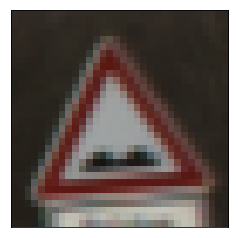

---------------------------------------------------------------------------------------------------------------
Image from validation set
19  <==>  Dangerous curve to the left


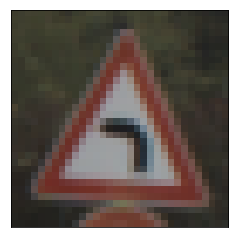

---------------------------------------------------------------------------------------------------------------
Image from testing set
10  <==>  No passing for vehicles over 3.5 metric tons


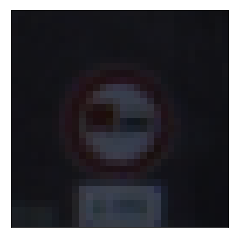

---------------------------------------------------------------------------------------------------------------


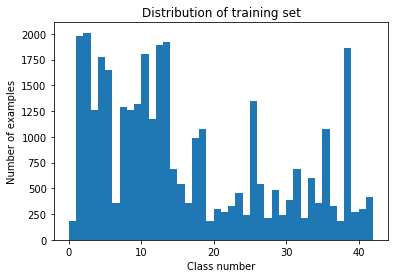

Stats of training set
Maximum distribution is for label 2 (Speed limit (50km/h)) with 2010 examples
Minimum distribution is for label 0 (Speed limit (20km/h)) 19 (Dangerous curve to the left) 37 (Go straight or left) with 180 examples
----------------------------------------------------------------------------------------------------------------


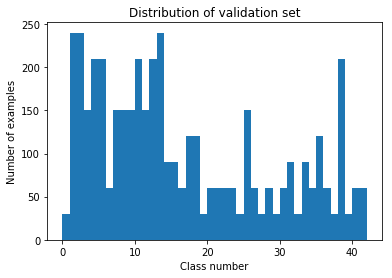

Stats of validation set
Maximum distribution is for label 1 (Speed limit (30km/h)) 2 (Speed limit (50km/h)) 13 (Yield) with 240 examples
Minimum distribution is for label 0 (Speed limit (20km/h)) 19 (Dangerous curve to the left) 24 (Road narrows on the right) 27 (Pedestrians) 29 (Bicycles crossing) 32 (End of all speed and passing limits) 37 (Go straight or left) 39 (Keep left) with 30 examples
----------------------------------------------------------------------------------------------------------------


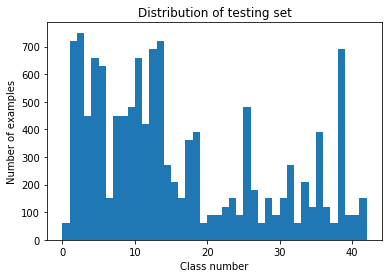

Stats of testing set
Maximum distribution is for label 2 (Speed limit (50km/h)) with 750 examples
Minimum distribution is for label 0 (Speed limit (20km/h)) 19 (Dangerous curve to the left) 27 (Pedestrians) 32 (End of all speed and passing limits) 37 (Go straight or left) with 60 examples


In [93]:
index = random.randint(0, len(X_train))
image = X_train[index]
print ('Image from training set')
print(y_train[index],' <==> ',y_labels['SignName'][y_train[index]])
plt.figure()
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()
print ('---------------------------------------------------------------------------------------------------------------')
index = random.randint(0, len(X_valid))
image = X_valid[index]
print ('Image from validation set')
print(y_valid[index],' <==> ',y_labels['SignName'][y_valid[index]])
plt.figure()
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()
print ('---------------------------------------------------------------------------------------------------------------')
index = random.randint(0, len(X_test))
image = X_test[index]
print ('Image from testing set')
print(y_test[index],' <==> ',y_labels['SignName'][y_test[index]])
plt.figure()
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()
print ('---------------------------------------------------------------------------------------------------------------')
n = np.arange(0, n_classes, 1)
plt.figure()
y, x, _ = plt.hist(y_train, n)
plt.xlabel('Class number')
plt.ylabel('Number of examples')
plt.title('Distribution of training set')
plt.savefig('Training Set')
plt.show()
x_max = np.where(y == y.max())
x_min = np.where(y == y.min())
print ('Stats of training set')
print ('Maximum distribution is for label ', end='')
for i in range(len(np.where(y == y.max())[0])):
    print ('{} ({}) '.format( x[x_max][i], y_labels['SignName'][x[x_max][i]]), end='')
print ('with {} examples'.format(int(y.max())))
print ('Minimum distribution is for label ', end='')
for i in range(len(np.where(y == y.min())[0])):
    print('{} ({}) '.format( x[x_min][i], y_labels['SignName'][x[x_min][i]]), end='')
print ('with {} examples'.format(int(y.min())))
print ('----------------------------------------------------------------------------------------------------------------')
n = np.arange(0, n_classes, 1)
plt.figure()
y, x, _ = plt.hist(y_valid, n)
plt.xlabel('Class number')
plt.ylabel('Number of examples')
plt.title('Distribution of validation set')
plt.savefig('Validation Set')
plt.show()
x_max = np.where(y == y.max())
x_min = np.where(y == y.min())
print ('Stats of validation set')
print ('Maximum distribution is for label ', end='')
for i in range(len(np.where(y == y.max())[0])):
    print ('{} ({}) '.format( x[x_max][i], y_labels['SignName'][x[x_max][i]]), end='')
print ('with {} examples'.format(int(y.max())))
print ('Minimum distribution is for label ', end='')
for i in range(len(np.where(y == y.min())[0])):
    print('{} ({}) '.format( x[x_min][i], y_labels['SignName'][x[x_min][i]]), end='')
print ('with {} examples'.format(int(y.min())))
print ('----------------------------------------------------------------------------------------------------------------')
n = np.arange(0, n_classes, 1)
plt.figure()
y, x, _ = plt.hist(y_test, n)
plt.xlabel('Class number')
plt.ylabel('Number of examples')
plt.title('Distribution of testing set')
plt.savefig('Testing Set')
plt.show()
x_max = np.where(y == y.max())
x_min = np.where(y == y.min())
print ('Stats of testing set')
print ('Maximum distribution is for label ', end='')
for i in range(len(np.where(y == y.max())[0])):
    print ('{} ({}) '.format( x[x_max][i], y_labels['SignName'][x[x_max][i]]), end='')
print ('with {} examples'.format(int(y.max())))
print ('Minimum distribution is for label ', end='')
for i in range(len(np.where(y == y.min())[0])):
    print('{} ({}) '.format( x[x_min][i], y_labels['SignName'][x[x_min][i]]), end='')
print ('with {} examples'.format(int(y.min())))

Data Preprocessing
---

In [94]:
def Preprocessing(X, mean_train = 0, stddev_train = 0, training = 0):
    """
        Preprocess the images. Preprocessed = (input - mean of the train)/(std. deviation of the train)
        X: Input images
        mean_train: Mean of the training set of the images. 0 if training set.
        stddev_train: Std. deviation of the training set of the images. 0 if training set.
        training: Flag to indicate if it is training. 1 if training set, 0 otherwise
        Returns preprocessed image
    """
    preprocessed = np.zeros([len(X), len(X[0]), len(X[0]), 1])
    for i in range(len(X)):
        preprocessed[i,:,:,0] = cv2.cvtColor(X[i,:,:,:], cv2.COLOR_RGB2GRAY)
    if training == 1:
        plt.imsave('stats/original_image.png', X[500])
        cv2.imwrite('stats/grayscale_image.png', preprocessed[500])
        mean_train = np.mean(preprocessed, axis = 0)
        stddev_train = np.std(preprocessed, axis = 0)
        preprocessed = (preprocessed - mean_train)
        cv2.imwrite('stats/Zero-centered.png', preprocessed[500])
        preprocessed = preprocessed / (stddev_train + 1e-5)
        return preprocessed, mean_train, stddev_train
    else:
        preprocessed = (preprocessed - mean_train)/(stddev_train + 1e-5)
        return preprocessed


pre_train, mean_train, stddev_train = Preprocessing(X_train, training = 1)
pre_valid = Preprocessing(X_valid, mean_train, stddev_train)

Network helper functions
---

In [95]:
def Convolution(data, w, b, stride = 1, padding = 'VALID'):
    """
        Convolution layer of the network
        data: input data to the layer
        w: Weight variable of this layer
        b: Bias variable of this layer
        stride: Default 1
        padding: Default VALID padding
    """
    return tf.nn.bias_add(tf.nn.conv2d(data, w, strides=[1, stride, stride, 1], padding=padding), b)

def Max_Pool(data, kSize = 2, stride = 2, padding = 'VALID'):
    """
        Max Pool layer of the network
        data: input data to the layer
        kSize: Kernel-size, default to 2
        stride: Default 2
        padding: Default VALID padding
    """
    return tf.nn.max_pool(data, [1, kSize, kSize, 1], [1, stride, stride, 1], padding)

def Avg_Pool(data, kSize = 2, stride = 2, padding = 'VALID'):
    """
        Avg Pool layer of the network
        data: input data to the layer
        kSize: Kernel size, default to 2
        stride: Default 2
        padding: Default VALID padding
    """
    return tf.nn.avg_pool(data, [1, kSize, kSize, 1], [1, stride, stride, 1], padding)

def ReLU(data):
    """
        ReLU layer of the network
        data: input data to the layer
    """
    return tf.nn.relu(data)

def FullyConnected(data, w, b):
    """
        Fully connected layer
        data: input data to the layer
        w: weight variable of the layer
        b: bias variable of the layer
    """
    return tf.add(tf.matmul(data, w), b)

def Dropout(data, keep_prob):
    """
        Dropout layer of the network
        data: input data to the layer
        keep_prob: Probability to keep the data
    """
    return tf.nn.dropout(data, keep_prob)

def InitializeWeights(size, mean, stddev):
    """
        Function to initialize weights
        size: Shape of the weight variable of the layer
        mean: Initial mean of the layer
        stddev: Initial standard deviation of the layer
    """
    return tf.Variable(tf.truncated_normal(size, mean=mean, stddev=stddev))

def InitializeBias(size):
    """
        Function to initialize bias
        size: Shape of the bias variable of the layer
    """
    return tf.Variable(tf.zeros(size))

def Flatten(data):
    """
        Flatten the data to the 1-D
        data: input data of the layer
    """
    return tf.contrib.layers.flatten(data)

Model
---

In [96]:
def model(input_data, n_classes, architecture):
    """
        Function defining the network architecture
        input_data: input data to the network
        n_classes: Number of output classes
        architecture: choose between 2 architectures, can take either 1 or 2
        Returns logits
    """
    mu = 0
    sigma = 0.1
    
    if architecture == 1:
        w = InitializeWeights([5, 5, 1, 6], mu, sigma)
        b = InitializeBias(6)
        logits = Convolution(input_data, w, b)
        
        logits = ReLU(logits)
        
        logits = Max_Pool(logits)
        
        w = InitializeWeights([5, 5, 6, 16], mu, sigma)
        b = InitializeBias(16)
        logits = Convolution(logits, w, b)
        
        logits = ReLU(logits)
        
        logits = Max_Pool(logits)
        
        logits = Flatten(logits)
        
        w = InitializeWeights([400, 120], mu, sigma)
        b = InitializeBias(120)
        logits = FullyConnected(logits, w, b)
        
        logits = ReLU(logits)
        
        w = InitializeWeights([120, 84], mu, sigma)
        b = InitializeBias(84)
        logits = FullyConnected(logits, w, b)
        
        logits = ReLU(logits)
        
        w = InitializeWeights([84, n_classes], mu, sigma)
        b = InitializeBias(n_classes)
        logits = FullyConnected(logits, w, b)
        
        return logits
        
    elif architecture == 2:
        
        # input = [None, 32, 32, 1], output = [None, 28, 28, 6]
        w1 = InitializeWeights([5, 5, 1, 6], mu, sigma)
        b1 = InitializeBias(6)
        conv1 = Convolution(input_data, w1, b1, 1, 'VALID')
        
        # no change in dimension
        relu1 = ReLU(conv1)
        
        # input = [None, 28, 28, 6], output = [None, 24, 24, 16]
        w2 = InitializeWeights([5, 5, 6, 16], mu, sigma)
        b2 = InitializeBias(16)
        conv2 = Convolution(relu1, w2, b2, 1, 'VALID')
        
        # no change in dimension
        relu2 = ReLU(conv2)

        # input = [None, 24, 24, :], output = [None, 12, 12, :]
        pool1 = Max_Pool(relu2)

        # input = [None, 12, 12, 16], output = [None, 8, 8, 32]
        w3 = InitializeWeights([5, 5, 16, 32], mu, sigma)
        b3 = InitializeBias(32)
        conv3 = Convolution(pool1, w3, b3, 1, 'VALID')

        # no change in dimension
        relu3 = ReLU(conv3)

        # input = [None, 8, 8, 32], output = [None, 4, 4, 64]
        w4 = InitializeWeights([5, 5, 32, 64], mu, sigma)
        b4 = InitializeBias(64)
        conv4 = Convolution(relu3, w4, b4, 1, 'VALID')

        # no change in dimension
        relu4 = ReLU(conv4)

        # input = [None, 4, 4, :], output = [None, 2, 2, :]
        pool2 = Max_Pool(relu4)

        # Flatten data
        fc0 = tf.contrib.layers.flatten(pool2)

        # Fully connected, input = [None, 256], output = [None, 128]
        w5 = InitializeWeights([256, 128], mu, sigma)
        b5 = InitializeBias(128)
        fc1 = FullyConnected(fc0, w5, b5)

        # no change in dimesion
        relu5 = ReLU(fc1)

        # Fully connected, input = [None, 128], output = [None, 64]
        w6 = InitializeWeights([128, 64], mu, sigma)
        b6 = InitializeBias(64)
        fc2 = FullyConnected(relu5, w6, b6)

        # no change in dimesion
        relu6 = ReLU(fc2)

        dr1 = Dropout(relu6, keep_prob)

        # Fully connected, input = [None, 64], output = [None, n_classes]
        w7 = InitializeWeights([64, n_classes], mu, sigma)
        b7 = InitializeBias(n_classes)
        logits = FullyConnected(dr1, w7, b7)

        return logits, [conv1, relu1, conv2, relu2, pool1, conv3, relu3, conv4, relu4, pool2]

In [97]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def top_k(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        values,indices = sess.run([top5_operation[0], top5_operation[1]], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        return values, indices

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)


rate = 0.1

logits, weights = model(x, n_classes, 2)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
top5_operation = tf.nn.top_k(tf.nn.softmax(logits), 5)
saver = tf.train.Saver()

def test_evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    correct_list = np.array([])
    predicted_list = np.array([])
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, correct_labels, predicted_labels = sess.run([accuracy_operation, tf.argmax(one_hot_y,1), tf.argmax(logits,1)]
                                                              , feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        correct_list = np.append(correct_list, correct_labels)
        predicted_list = np.append(predicted_list, predicted_labels)
#         print ('Correct Labels: ', correct_labels, 'Predicted Labels: ', predicted_labels)
    return total_accuracy/num_examples, correct_list, predicted_list


EPOCHS = 15
BATCH_SIZE = 128

Network training
---

In [98]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(pre_train)
    loss_vector = []

    print("Training...")
    print()
    for i in range(EPOCHS):
        count = 0
        loss_sum = 0
        training_acc_sum = 0
        pre_train, y_train = shuffle(pre_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = pre_train[offset:end], y_train[offset:end]
            _, loss, training_accuracy = sess.run([training_operation, loss_operation, accuracy_operation],feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            loss_sum += loss
            count = count + 1
            training_acc_sum += training_accuracy
        validation_accuracy = evaluate(pre_valid, y_valid)
        avg_loss = loss_sum / count
        avg_training_acc = training_acc_sum/count
        loss_vector.append([i, avg_loss, validation_accuracy, avg_training_acc])        
        print("EPOCH {} ...".format(i+1))
        print ('Loss = {:.3f}'.format(avg_loss))
        print("Training Accuracy = {:.3f}".format(avg_training_acc))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './tsc')
    sess.close()
    print("Model saved")

Training...

EPOCH 1 ...
Loss = 2.138
Training Accuracy = 0.420
Validation Accuracy = 0.793

EPOCH 2 ...
Loss = 0.623
Training Accuracy = 0.814
Validation Accuracy = 0.907

EPOCH 3 ...
Loss = 0.360
Training Accuracy = 0.895
Validation Accuracy = 0.917

EPOCH 4 ...
Loss = 0.238
Training Accuracy = 0.930
Validation Accuracy = 0.934

EPOCH 5 ...
Loss = 0.186
Training Accuracy = 0.945
Validation Accuracy = 0.935

EPOCH 6 ...
Loss = 0.153
Training Accuracy = 0.954
Validation Accuracy = 0.931

EPOCH 7 ...
Loss = 0.122
Training Accuracy = 0.962
Validation Accuracy = 0.954

EPOCH 8 ...
Loss = 0.104
Training Accuracy = 0.968
Validation Accuracy = 0.947

EPOCH 9 ...
Loss = 0.092
Training Accuracy = 0.971
Validation Accuracy = 0.944

EPOCH 10 ...
Loss = 0.085
Training Accuracy = 0.974
Validation Accuracy = 0.955

EPOCH 11 ...
Loss = 0.069
Training Accuracy = 0.978
Validation Accuracy = 0.943

EPOCH 12 ...
Loss = 0.054
Training Accuracy = 0.983
Validation Accuracy = 0.952

EPOCH 13 ...
Loss = 0.06

Analysis graphs for loss and accuracy
---

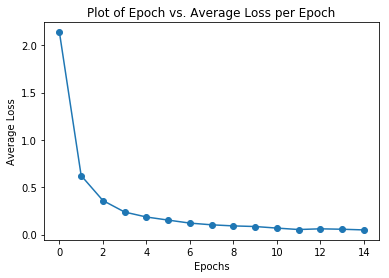

In [99]:
c = [loss_vector[i][0] for i in range(len(loss_vector))]
l = [loss_vector[i][1] for i in range(len(loss_vector))]
plt.plot(c, l, '-o', label='Average Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Plot of Epoch vs. Average Loss per Epoch')
plt.show()

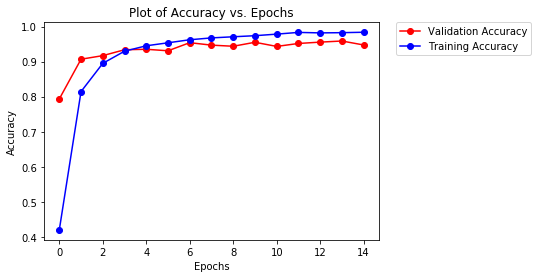

In [100]:
v = [loss_vector[i][2] for i in range(len(loss_vector))]
t = [loss_vector[i][3] for i in range(len(loss_vector))]
c = [loss_vector[i][0] for i in range(len(loss_vector))]
plt.plot(c, v, '-or', label='Validation Accuracy')
plt.plot(c, t, '-ob', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs. Epochs')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.show()

Model evaluation against test set and new images found on internet
---

In [101]:
with tf.Session() as sess:
    saver.restore(sess, './tsc')
    pre_test = Preprocessing(X_test, mean_train, stddev_train)
    test_accuracy = evaluate(pre_test, y_test)
    print ('Testing accuracy on test set = {:.3f}'.format(test_accuracy))
    
    test_set = []
    test_images = ['test_images/priority.jpg',  
                   'test_images/yield.jpg', 
                   'test_images/german-road-signs-pedestrians.png', 
                   'test_images/no-overtaking-sign.png',
                   'test_images/traffic_signal_ahead.png',
                   'test_images/children_crossing.jpg',
                  'test_images/70kmph.jpg',
                  'test_images/stop.jpg',
                  'test_images/keep_right.png',
                  'test_images/yield_2.jpg']
    test_labels = np.array([12, 13, 27, 9, 26, 28, 4, 14, 38, 13])
    for img_file in test_images:
        img = cv2.imread(img_file)
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32,32))
        test_set.append(img)
    test_set = np.asarray(test_set)
    pre_test1 = Preprocessing(test_set, mean_train, stddev_train)
    test1_accuracy = evaluate(pre_test1, test_labels)
    print ('Testing accuracy on new images = {:.3f}'.format(test1_accuracy))
    values, indices = top_k(pre_test1, test_labels)
    for i in range(len(test_labels)):
        print ('\nOriginal label: {}\t{}\nTop 5 candidates are:'.format(test_labels[i], y_labels['SignName'][test_labels[i]]))
        for j in range(len(values[0])):
            print ('{}.\t{:.3f}\t{}\t{}'.format(j+1, values[i][j], indices[i][j], y_labels['SignName'][indices[i][j]]))
    sess.close()

INFO:tensorflow:Restoring parameters from ./tsc
Testing accuracy on test set = 0.941
Testing accuracy on new images = 0.600

Original label: 12	Priority road
Top 5 candidates are:
1.	1.000	12	Priority road
2.	0.000	40	Roundabout mandatory
3.	0.000	9	No passing
4.	0.000	11	Right-of-way at the next intersection
5.	0.000	32	End of all speed and passing limits

Original label: 13	Yield
Top 5 candidates are:
1.	0.913	18	General caution
2.	0.082	42	End of no passing by vehicles over 3.5 metric tons
3.	0.002	12	Priority road
4.	0.001	41	End of no passing
5.	0.001	11	Right-of-way at the next intersection

Original label: 27	Pedestrians
Top 5 candidates are:
1.	1.000	27	Pedestrians
2.	0.000	18	General caution
3.	0.000	11	Right-of-way at the next intersection
4.	0.000	26	Traffic signals
5.	0.000	25	Road work

Original label: 9	No passing
Top 5 candidates are:
1.	0.989	9	No passing
2.	0.011	41	End of no passing
3.	0.000	40	Roundabout mandatory
4.	0.000	12	Priority road
5.	0.000	10	No passing for 

Visualization of the network state
---

INFO:tensorflow:Restoring parameters from ./tsc
After Conv1


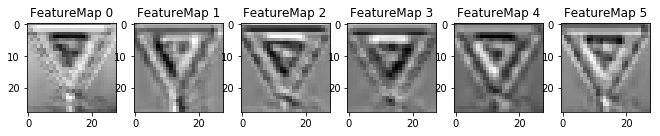

After ReLU1


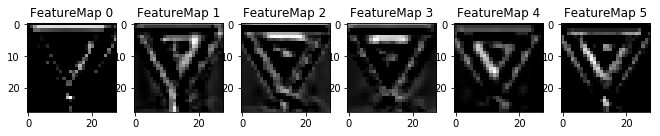

After Conv2


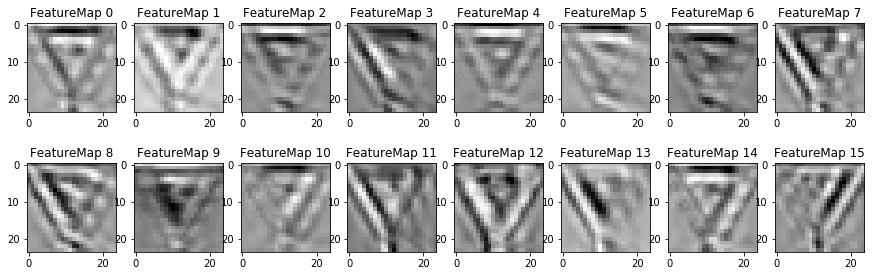

After ReLU2


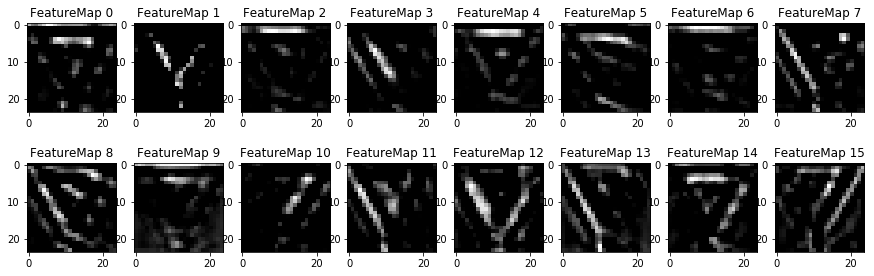

After Pool1


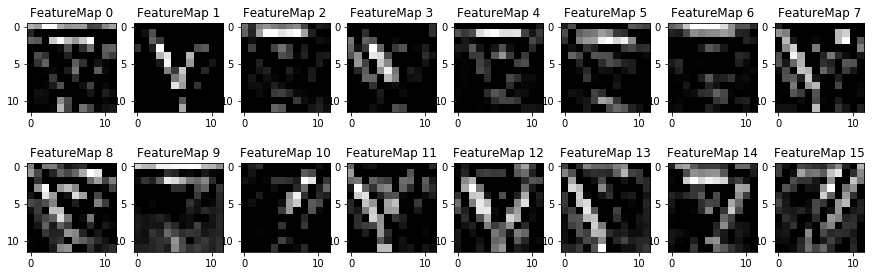

In [107]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, save_name=''):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        plt.imsave('stats/' + save_name + '_' + str(featuremap) + '.png', activation[0,:,:, featuremap])
    plt.show()
            
with tf.Session() as sess:
    saver.restore(sess, './tsc')
    display_test = np.zeros([1, 32, 32, 1])
    display_test[0, :, :, :] = pre_test1[9]
    print ('After Conv1')
    outputFeatureMap(display_test, weights[0], save_name='conv1')
    print ('After ReLU1')
    outputFeatureMap(display_test, weights[1], save_name='relu1')
    print ('After Conv2')
    outputFeatureMap(display_test, weights[2], save_name='conv2')
    print ('After ReLU2')
    outputFeatureMap(display_test, weights[3], save_name='relu2')
    print ('After Pool1')
    outputFeatureMap(display_test, weights[4], save_name='pool1')
    sess.close()

Analysis of the test set
---

INFO:tensorflow:Restoring parameters from ./tsc
Testing accuracy = 0.941


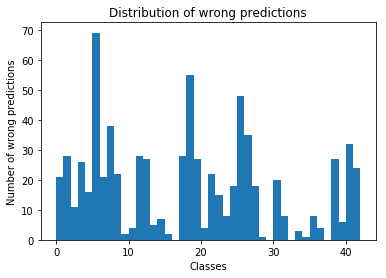

Label: 5 (Speed limit (80km/h))
True Positives:  561.0
False Positives:  34.0
False Negatives:  69.0
Precision: 0.943
Recall: 0.890
------------------------------------------------------------------------------------------
Label: 6 (End of speed limit (80km/h))
True Positives:  129.0
False Positives:  1.0
False Negatives:  21.0
Precision: 0.992
Recall: 0.860
------------------------------------------------------------------------------------------
Label: 18 (General caution)
True Positives:  335.0
False Positives:  36.0
False Negatives:  55.0
Precision: 0.903
Recall: 0.859
------------------------------------------------------------------------------------------
Label: 31 (Wild animals crossing)
True Positives:  262.0
False Positives:  15.0
False Negatives:  8.0
Precision: 0.946
Recall: 0.970
------------------------------------------------------------------------------------------
Label: 42 (End of no passing by vehicles over 3.5 metric tons)
True Positives:  76.0
False Positives:  1.

In [108]:
with tf.Session() as sess:
    saver.restore(sess, './tsc')
    pre_test = Preprocessing(X_test, mean_train, stddev_train)
    test_accuracy, correct_list, predicted_list = test_evaluate(pre_test, y_test)
    print ('Testing accuracy = {:.3f}'.format(test_accuracy))
    
    wrong_prediction = tf.not_equal(correct_list, predicted_list)
    error = tf.cast(wrong_prediction, tf.int32).eval()
    wrong_labels = np.array([])
    for i in range(len(error)):
        if error[i] == 1:
            wrong_labels = np.append(wrong_labels, correct_list[i])
    n = np.arange(0, n_classes, 1)
    plt.hist(wrong_labels, n)
    plt.title('Distribution of wrong predictions')
    plt.xlabel('Classes')
    plt.ylabel('Number of wrong predictions')
    plt.savefig('stats/test_set_wrong_predictions.png')
    plt.show()
    
    analysis_labels = [5, 6, 18, 31, 42, 7, 2]
    for l in analysis_labels:
        tp = 0.
        fn = 0. 
        fp = 0.
        for i in range(correct_list.shape[0]):
            if correct_list[i] == l and predicted_list[i] == l:
                tp = tp + 1
            elif correct_list[i] == l and predicted_list[i] != l:
                fn = fn + 1
            elif correct_list[i] != l and predicted_list[i] == l:
                fp = fp + 1
        precision = float(tp) / float(tp + fp)
        recall = float(tp) / float(tp + fn)
        print ('Label: {} ({})'.format(l, y_labels['SignName'][l]))
        print ('True Positives: ', tp)
        print ('False Positives: ', fp)
        print ('False Negatives: ', fn)
        print ('Precision: {:.3f}'.format(precision))
        print ('Recall: {:.3f}'.format(recall))
        print ('------------------------------------------------------------------------------------------')
               
    
    sess.close()